In [8]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import prettytable
prettytable.DEFAULT = 'DEFAULT'

#### Enabling SQL magic commands in Jupyter

In [2]:
# Load SQL magic extension
%load_ext sql

#### Download and Load Dataset

In [5]:
# Download Netflix dataset
import urllib.request

# Netflix dataset URL (from Kaggle)
url = "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2021/2021-04-20/netflix_titles.csv"
urllib.request.urlretrieve(url, "netflix_titles.csv")

# Load data into pandas
df = pd.read_csv("netflix_titles.csv")
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nColumns:", list(df.columns))
print("\nFirst few rows:")
df.head()

Dataset loaded: 7787 rows, 12 columns

Columns: ['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']

First few rows:


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


#### Setting up our SQL database and loading data

In [6]:
# Create SQLite connection
conn = sqlite3.connect('netflix_analysis.db')

# Load data into SQLite table
df.to_sql('netflix_content', conn, if_exists='replace', index=False)

# Connect SQL magic to our database
%sql sqlite:///netflix_analysis.db

#### Understanding our dataset structure and basic statistics

In [9]:
%%sql
-- Check total number of records
SELECT COUNT(*) as total_content 
FROM netflix_content;

 * sqlite:///netflix_analysis.db
Done.


total_content
7787


In [10]:
%%sql
-- View table structure and sample data
SELECT * 
FROM netflix_content 
LIMIT 5;

 * sqlite:///netflix_analysis.db
Done.


show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
s1,TV Show,3%,None,"João Miguel, Bianca Comparato, Michel Gomes, Rodolfo Valente, Vaneza Oliveira, Rafael Lozano, Viviane Porto, Mel Fronckowiak, Sergio Mamberti, Zezé Motta, Celso Frateschi",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi & Fantasy","In a future where the elite inhabit an island paradise far from the crowded slums, you get one chance to join the 3% saved from squalor."
s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, Azalia Ortiz, Octavio Michel, Carmen Beato",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies","After a devastating earthquake hits Mexico City, trapped survivors from all walks of life wait to be rescued while trying desperately to stay alive."
s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence Koh, Tommy Kuan, Josh Lai, Mark Lee, Susan Leong, Benjamin Lim",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow soldiers are forced to confront a terrifying secret that's haunting their jungle island training camp."
s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly, Christopher Plummer, Crispin Glover, Martin Landau, Fred Tatasciore, Alan Oppenheimer, Tom Kane",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi & Fantasy","In a postapocalyptic world, rag-doll robots hide in fear from dangerous machines out to exterminate them, until a brave newcomer joins the group."
s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aaron Yoo, Liza Lapira, Jacob Pitts, Laurence Fishburne, Jack McGee, Josh Gad, Sam Golzari, Helen Carey, Jack Gilpin",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-counting experts with the intent of swindling millions out of Las Vegas casinos by playing blackjack.


In [15]:
%%sql
SELECT 
    COUNT(*) AS total_rows,
    COUNT(show_id) AS show_id_count,
    COUNT(title) AS title_count,
    COUNT(director) AS director_count,
    COUNT("cast") AS cast_count,
    COUNT(country) AS country_count,
    COUNT(date_added) AS date_added_count,
    COUNT(release_year) AS release_year_count,
    COUNT(rating) AS rating_count,
    COUNT(duration) AS duration_count
FROM netflix_content


 * sqlite:///netflix_analysis.db
Done.


total_rows,show_id_count,title_count,director_count,cast_count,country_count,date_added_count,release_year_count,rating_count,duration_count
7787,7787,7787,5398,7069,7280,7777,7787,7780,7787


#### Analyzing the distribution of movies vs TV shows

In [16]:
%%sql
-- Content type distribution
SELECT 
    type,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM netflix_content), 2) as percentage
FROM netflix_content
GROUP BY type
ORDER BY count DESC;

 * sqlite:///netflix_analysis.db
Done.


type,count,percentage
Movie,5377,69.05
TV Show,2410,30.95


In [17]:
%%sql
-- Top 10 genres/categories
SELECT 
    listed_in as genre,
    COUNT(*) as content_count
FROM netflix_content
WHERE listed_in IS NOT NULL
GROUP BY listed_in
ORDER BY content_count DESC
LIMIT 10;

 * sqlite:///netflix_analysis.db
Done.


genre,content_count
Documentaries,334
Stand-Up Comedy,321
"Dramas, International Movies",320
"Comedies, Dramas, International Movies",243
"Dramas, Independent Movies, International Movies",215
Kids' TV,205
Children & Family Movies,177
"Documentaries, International Movies",172
"Children & Family Movies, Comedies",169
"Comedies, International Movies",161


#### Analyzing content trends over time

In [18]:
%%sql
-- Content added per year (handling date format)
SELECT 
    SUBSTR(date_added, -4) as year_added,
    COUNT(*) as content_added,
    type
FROM netflix_content
WHERE date_added IS NOT NULL
GROUP BY SUBSTR(date_added, -4), type
ORDER BY year_added DESC, type;

 * sqlite:///netflix_analysis.db
Done.


year_added,content_added,type
2021,88,Movie
2021,29,TV Show
2020,1312,Movie
2020,697,TV Show
2019,1497,Movie
2019,656,TV Show
2018,1255,Movie
2018,430,TV Show
2017,864,Movie
2017,361,TV Show


In [19]:
%%sql
-- Release year analysis
SELECT 
    release_year,
    COUNT(*) as total_content,
    SUM(CASE WHEN type = 'Movie' THEN 1 ELSE 0 END) as movies,
    SUM(CASE WHEN type = 'TV Show' THEN 1 ELSE 0 END) as tv_shows
FROM netflix_content
WHERE release_year >= 2000
GROUP BY release_year
ORDER BY release_year DESC
LIMIT 20;

 * sqlite:///netflix_analysis.db
Done.


release_year,total_content,movies,tv_shows
2021,31,12,19
2020,868,411,457
2019,996,582,414
2018,1121,734,387
2017,1012,744,268
2016,882,642,240
2015,541,382,159
2014,334,244,90
2013,267,202,65
2012,219,158,61


#### Analyzing content by country and region

In [20]:
%%sql
-- Top countries producing Netflix content
SELECT 
    TRIM(country) as country,
    COUNT(*) as content_count,
    type
FROM netflix_content
WHERE country IS NOT NULL AND country != ''
GROUP BY TRIM(country), type
HAVING COUNT(*) >= 10
ORDER BY content_count DESC
LIMIT 15;

 * sqlite:///netflix_analysis.db
Done.


country,content_count,type
United States,1850,Movie
India,852,Movie
United States,705,TV Show
United Kingdom,204,TV Show
United Kingdom,193,Movie
Japan,157,TV Show
South Korea,147,TV Show
Canada,118,Movie
Egypt,89,Movie
Spain,89,Movie


In [21]:
%%sql
-- Content ratings analysis
SELECT 
    rating,
    COUNT(*) as count,
    type,
    ROUND(AVG(release_year), 0) as avg_release_year
FROM netflix_content
WHERE rating IS NOT NULL
GROUP BY rating, type
ORDER BY count DESC;

 * sqlite:///netflix_analysis.db
Done.


rating,count,type,avg_release_year
TV-MA,1845,Movie,2016.0
TV-14,1272,Movie,2012.0
TV-MA,1018,TV Show,2018.0
R,663,Movie,2011.0
TV-14,659,TV Show,2015.0
TV-PG,505,Movie,2012.0
PG-13,386,Movie,2009.0
TV-PG,301,TV Show,2015.0
PG,247,Movie,2009.0
TV-Y7,176,TV Show,2015.0


In [22]:
%%sql
-- Running total of content added each year with window functions
WITH yearly_content AS (
    SELECT 
        SUBSTR(date_added, -4) as year_added,
        COUNT(*) as yearly_count
    FROM netflix_content
    WHERE date_added IS NOT NULL
    GROUP BY SUBSTR(date_added, -4)
)
SELECT 
    year_added,
    yearly_count,
    SUM(yearly_count) OVER (ORDER BY year_added) as running_total,
    LAG(yearly_count) OVER (ORDER BY year_added) as previous_year,
    yearly_count - LAG(yearly_count) OVER (ORDER BY year_added) as year_over_year_change
FROM yearly_content
ORDER BY year_added;

 * sqlite:///netflix_analysis.db
Done.


year_added,yearly_count,running_total,previous_year,year_over_year_change
2008,2,2,None,None
2009,2,4,2,0
2010,1,5,2,-1
2011,13,18,1,12
2012,3,21,13,-10
2013,11,32,3,8
2014,25,57,11,14
2015,88,145,25,63
2016,443,588,88,355
2017,1225,1813,443,782


In [23]:
%%sql
-- Top directors with their content statistics using window functions
WITH director_stats AS (
    SELECT 
        director,
        COUNT(*) as total_content,
        AVG(release_year) as avg_release_year,
        MIN(release_year) as earliest_release,
        MAX(release_year) as latest_release
    FROM netflix_content
    WHERE director IS NOT NULL AND director != ''
    GROUP BY director
    HAVING COUNT(*) >= 3
)
SELECT 
    director,
    total_content,
    ROUND(avg_release_year, 0) as avg_release_year,
    earliest_release,
    latest_release,
    latest_release - earliest_release as career_span,
    RANK() OVER (ORDER BY total_content DESC) as content_rank,
    NTILE(4) OVER (ORDER BY total_content) as quartile
FROM director_stats
ORDER BY total_content DESC
LIMIT 20;

 * sqlite:///netflix_analysis.db
Done.


director,total_content,avg_release_year,earliest_release,latest_release,career_span,content_rank,quartile
"Raúl Campos, Jan Suter",18,2018.0,2016,2018,2,1,4
Marcus Raboy,16,2018.0,2012,2020,8,2,4
Jay Karas,14,2016.0,2012,2020,8,3,4
Cathy Garcia-Molina,13,2014.0,2008,2019,11,4,4
Jay Chapman,12,2015.0,2012,2018,6,5,4
Martin Scorsese,12,1994.0,1967,2019,52,5,4
Youssef Chahine,12,1976.0,1954,1999,45,5,4
Steven Spielberg,10,1998.0,1981,2012,31,8,4
David Dhawan,9,2005.0,1997,2017,20,9,4
Hakan Algül,8,2014.0,2010,2018,8,10,4


#### Combining SQL results with Python visualization

 * sqlite:///netflix_analysis.db
Done.


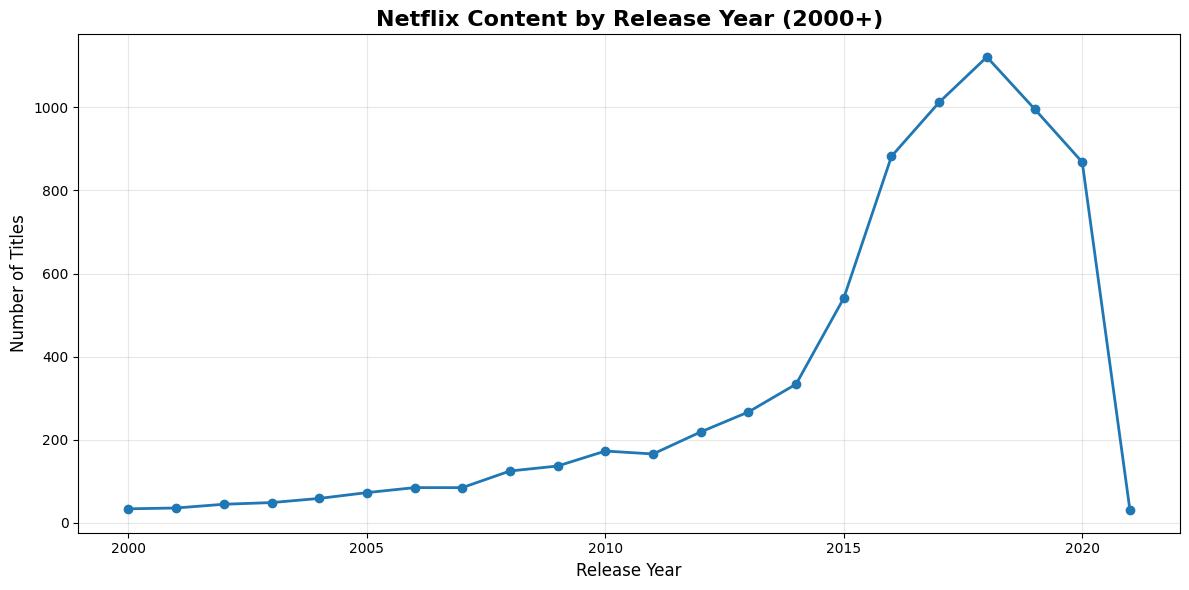

In [24]:
# Execute SQL query and create visualization
content_by_year = %sql SELECT release_year, COUNT(*) as count FROM netflix_content WHERE release_year >= 2000 GROUP BY release_year ORDER BY release_year

# Convert to DataFrame
df_year = content_by_year.DataFrame()

# Create visualization
plt.figure(figsize=(12, 6))
plt.plot(df_year['release_year'], df_year['count'], marker='o', linewidth=2, markersize=6)
plt.title('Netflix Content by Release Year (2000+)', fontsize=16, fontweight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

 * sqlite:///netflix_analysis.db
Done.


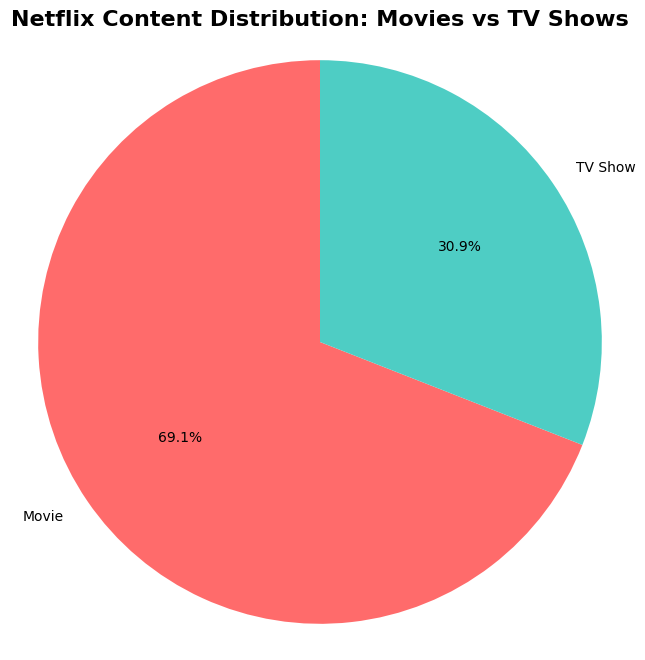

In [25]:
# Content type distribution pie chart
content_type = %sql SELECT type, COUNT(*) as count FROM netflix_content GROUP BY type

df_type = content_type.DataFrame()

plt.figure(figsize=(8, 8))
plt.pie(df_type['count'], labels=df_type['type'], autopct='%1.1f%%', startangle=90, 
        colors=['#FF6B6B', '#4ECDC4'])
plt.title('Netflix Content Distribution: Movies vs TV Shows', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

In [26]:
%%sql
-- Executive summary of Netflix content analysis
WITH summary_stats AS (
    SELECT 
        COUNT(*) as total_content,
        COUNT(DISTINCT type) as content_types,
        COUNT(DISTINCT rating) as rating_categories,
        COUNT(DISTINCT country) as countries,
        MIN(release_year) as oldest_content,
        MAX(release_year) as newest_content,
        ROUND(AVG(release_year), 0) as avg_release_year
    FROM netflix_content
    WHERE country IS NOT NULL AND rating IS NOT NULL
)
SELECT 
    'Netflix Content Analysis Summary' as report_title,
    total_content || ' total titles analyzed' as content_volume,
    content_types || ' content types (Movies & TV Shows)' as content_variety,
    rating_categories || ' different rating categories' as rating_diversity,
    countries || ' countries represented' as global_reach,
    'Content spans from ' || oldest_content || ' to ' || newest_content as time_range,
    'Average release year: ' || avg_release_year as content_recency
FROM summary_stats;

 * sqlite:///netflix_analysis.db
Done.


report_title,content_volume,content_variety,rating_diversity,global_reach,time_range,content_recency
Netflix Content Analysis Summary,7274 total titles analyzed,2 content types (Movies & TV Shows),14 different rating categories,681 countries represented,Content spans from 1942 to 2021,Average release year: 2014.0


In [27]:
%%sql
-- Content distribution by decade with performance metrics
SELECT 
    CASE 
        WHEN release_year >= 2020 THEN '2020s'
        WHEN release_year >= 2010 THEN '2010s'
        WHEN release_year >= 2000 THEN '2000s'
        WHEN release_year >= 1990 THEN '1990s'
        WHEN release_year >= 1980 THEN '1980s'
        ELSE 'Pre-1980s'
    END as decade,
    type,
    COUNT(*) as content_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentage_of_total,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY type), 2) as percentage_of_type,
    MIN(release_year) as earliest_year,
    MAX(release_year) as latest_year
FROM netflix_content
WHERE release_year IS NOT NULL
GROUP BY 
    CASE 
        WHEN release_year >= 2020 THEN '2020s'
        WHEN release_year >= 2010 THEN '2010s'
        WHEN release_year >= 2000 THEN '2000s'
        WHEN release_year >= 1990 THEN '1990s'
        WHEN release_year >= 1980 THEN '1980s'
        ELSE 'Pre-1980s'
    END,
    type
ORDER BY earliest_year DESC, type;

 * sqlite:///netflix_analysis.db
Done.


decade,type,content_count,percentage_of_total,percentage_of_type,earliest_year,latest_year
2020s,Movie,423,5.43,7.87,2020,2021
2020s,TV Show,476,6.11,19.75,2020,2021
2010s,Movie,3951,50.74,73.48,2010,2019
2010s,TV Show,1760,22.6,73.03,2010,2019
2000s,Movie,601,7.72,11.18,2000,2009
2000s,TV Show,127,1.63,5.27,2000,2009
1990s,Movie,194,2.49,3.61,1990,1999
1990s,TV Show,31,0.4,1.29,1990,1999
1980s,TV Show,7,0.09,0.29,1981,1989
1980s,Movie,99,1.27,1.84,1980,1989
